In [1]:
import numpy as np
from scipy.interpolate import CubicSpline
from scipy import integrate, sparse
from scipy.stats import pearsonr
from scipy.sparse.linalg import eigs, ArpackNoConvergence
from scipy.sparse import coo_matrix
import math 
import networkx as nx
import itertools
import csv
import time
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [20, 5]
# Set seed for reproducibility
np.random.seed(1)
from math import comb
import h5py
from mpi4py import MPI
import traceback
import logging
import importlib
import pandas as pd

In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath('/home/seyfdall/network_theory/rescomp/rescomp'))
import ResComp
import chaosode

In [3]:
sys.path.insert(0, os.path.abspath('/home/seyfdall/network_theory/Thinned_Rescomp/utils/'))
print(sys.path)
import helper
import driver

['/home/seyfdall/network_theory/Thinned_Rescomp/utils', '/home/seyfdall/network_theory/rescomp/rescomp', '/home/seyfdall/.conda/envs/reservoir/lib/python313.zip', '/home/seyfdall/.conda/envs/reservoir/lib/python3.13', '/home/seyfdall/.conda/envs/reservoir/lib/python3.13/lib-dynload', '', '/home/seyfdall/.conda/envs/reservoir/lib/python3.13/site-packages']


### Test Diameter over Various Graphs From Erdos to Sparse

In [ ]:
def create_graphs(n, c_values, samples_per_c, func):
    graphs = {}
    for c in c_values:
        graphs[c] = [func(n, c) for _ in range(samples_per_c)]

def find_diameters():
    avg_diameters = []

for c, graphs_for_c in graphs.items():
    diameters = []

    for G in graphs_for_c:
        if G.number_of_edges() == 0:
            continue

        # Largest connected component
        largest_cc = max(nx.connected_components(G), key=len)
        H = G.subgraph(largest_cc)

        # Diameter requires connectivity
        if H.number_of_nodes() > 1:
            diameters.append(nx.diameter(H))

    avg_diameters.append((c, np.mean(diameters)))

In [17]:
n = 400
# c_values = [0.5,0.6,0.7,0.8,0.9,1, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4, 2.5]
c_values = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5,9,9.5,10]
samples_per_c = 30

In [18]:
graphs = {}

for c in c_values:
    p = c / n
    graphs[c] = [
        nx.erdos_renyi_graph(n, p)
        for _ in range(samples_per_c)
    ]

In [19]:
avg_diameters = []

for c, graphs_for_c in graphs.items():
    diameters = []

    for G in graphs_for_c:
        if G.number_of_edges() == 0:
            continue

        # Largest connected component
        largest_cc = max(nx.connected_components(G), key=len)
        H = G.subgraph(largest_cc)

        # Diameter requires connectivity
        if H.number_of_nodes() > 1:
            diameters.append(nx.diameter(H))

    avg_diameters.append((c, np.mean(diameters)))

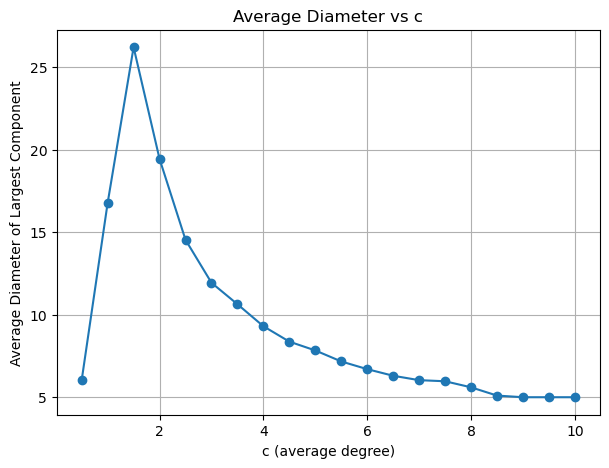

In [20]:
c_vals, avg_diams = zip(*avg_diameters)

plt.figure(figsize=(7, 5))
plt.plot(c_vals, avg_diams, marker='o')
plt.xlabel("c (average degree)")
plt.ylabel("Average Diameter of Largest Component")
plt.title("Average Diameter vs c")
plt.grid(True)
plt.show()

In [21]:
graphs = {}

for c in c_values:
    p = c / n
    for _ in range(samples_per_c):
        A = sparse.random(n,n, density=p, dtype=float, format="lil")
        A = (A + A.T) / 2.
        G = nx.from_scipy_sparse_array(A, create_using=nx.Graph, edge_attribute='weight')
        if c not in graphs.keys():
            graphs[c] = [G]
        else:
            graphs[c].append(G)

In [22]:
avg_diameters = []

for c, graphs_for_c in graphs.items():
    diameters = []

    for G in graphs_for_c:
        if G.number_of_edges() == 0:
            continue

        # Largest connected component
        largest_cc = max(nx.connected_components(G), key=len)
        H = G.subgraph(largest_cc)

        # Diameter requires connectivity
        if H.number_of_nodes() > 1:
            diameters.append(nx.diameter(H))

    avg_diameters.append((c, np.mean(diameters)))

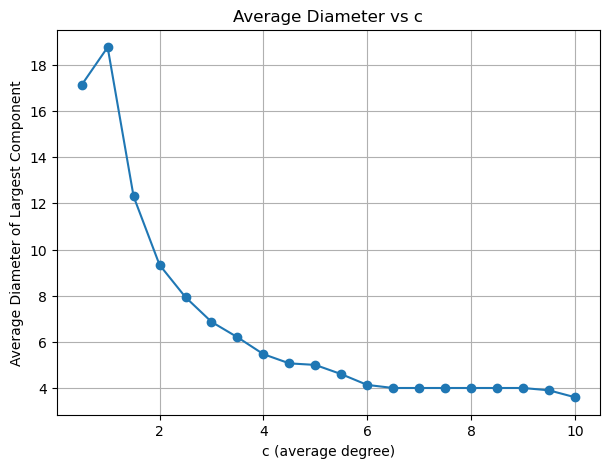

In [23]:
c_vals, avg_diams = zip(*avg_diameters)

plt.figure(figsize=(7, 5))
plt.plot(c_vals, avg_diams, marker='o')
plt.xlabel("c (average degree)")
plt.ylabel("Average Diameter of Largest Component")
plt.title("Average Diameter vs c")
plt.grid(True)
plt.show()

In [24]:
graphs = {}

for c in c_values:
    p = c / n
    for _ in range(samples_per_c):
        # Upper triangle only (no self-loops)
        upper = sparse.triu(
            sparse.random(
                n, n,
                density=p,
                data_rvs=lambda k: np.ones(k)
            ),
            k=1
        )

        A = upper + upper.T
        G = nx.from_scipy_sparse_array(A)
        if c not in graphs.keys():
            graphs[c] = [G]
        else:
            graphs[c].append(G)

In [25]:
avg_diameters = []

for c, graphs_for_c in graphs.items():
    diameters = []

    for G in graphs_for_c:
        if G.number_of_edges() == 0:
            continue

        # Largest connected component
        largest_cc = max(nx.connected_components(G), key=len)
        H = G.subgraph(largest_cc)

        # Diameter requires connectivity
        if H.number_of_nodes() > 1:
            diameters.append(nx.diameter(H))

    avg_diameters.append((c, np.mean(diameters)))

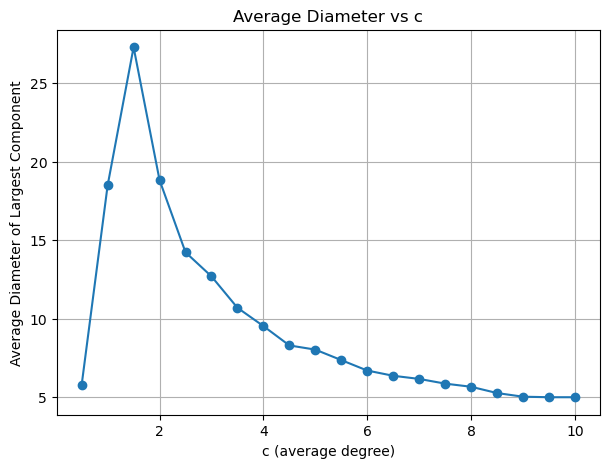

In [26]:
c_vals, avg_diams = zip(*avg_diameters)

plt.figure(figsize=(7, 5))
plt.plot(c_vals, avg_diams, marker='o')
plt.xlabel("c (average degree)")
plt.ylabel("Average Diameter of Largest Component")
plt.title("Average Diameter vs c")
plt.grid(True)
plt.show()

### Test Diameter

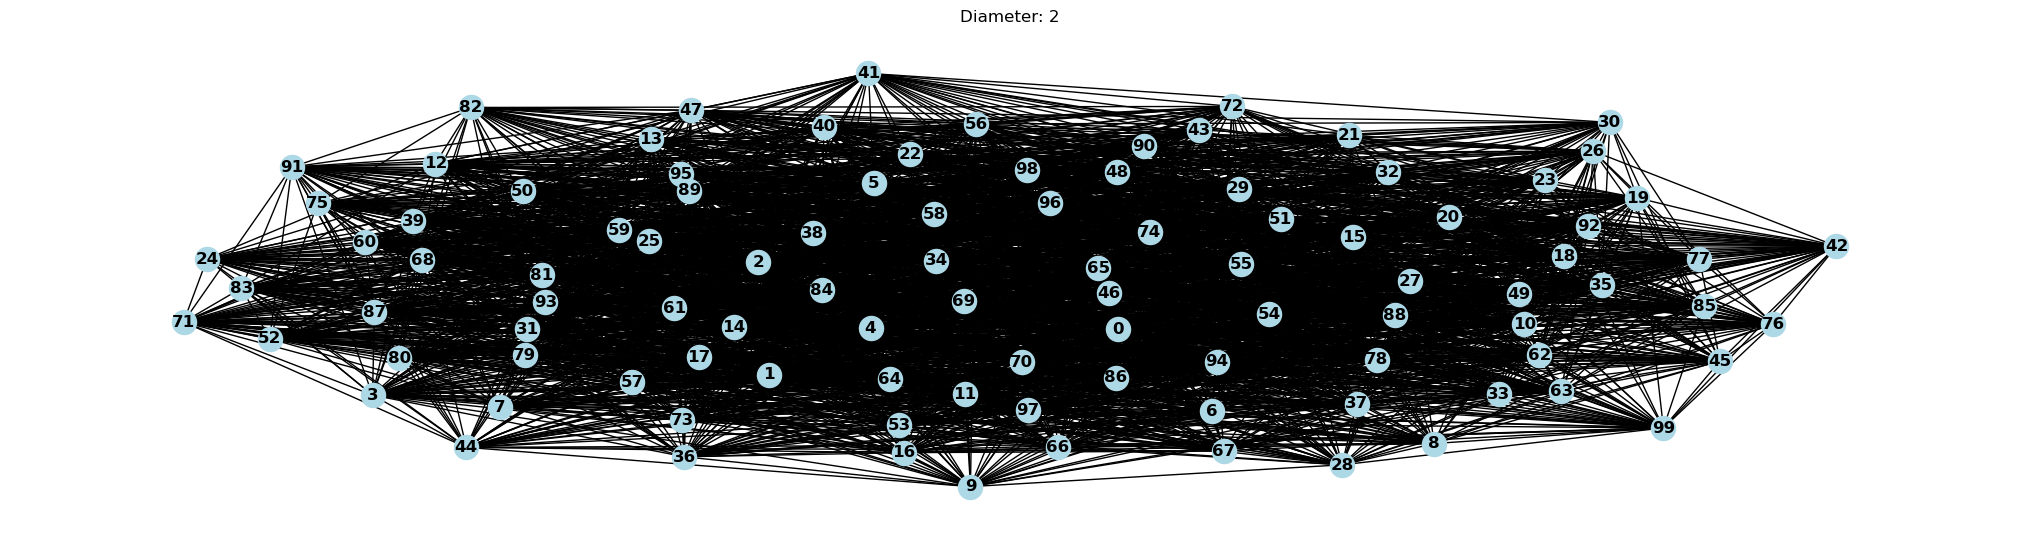

In [16]:
def calculate_diameters(A):
    """Calculate 3 diameters of the graph formed from the adjacency matrix A
    
    Returns:
        giant_diam (int): diameter of the giant component (or largest component if the giant doesn't exist)

        largest_diam (int): largest diameter found over all components
        
        average_diam (int): average over all diameters
    """
    G = nx.from_numpy_array(A)

    giant_diam = 0
    giant_size = 0
    largest_diam = 0
    sum_diam = 0

    connected_components = list(nx.connected_components(G))

    for c in connected_components:
        G_sub = G.subgraph(c)
        curr_diam = nx.diameter(G_sub)
        m = len(G_sub)

        # Update Giant Diameter
        if m > giant_size:
            giant_diam = curr_diam
            giant_size = m
        elif m == giant_size and curr_diam > giant_diam:
            giant_diam = curr_diam

        # Update Largest Diameter
        if curr_diam > largest_diam:
            largest_diam = curr_diam

        # Update Average Diameter
        sum_diam += curr_diam

    average_diam = sum_diam / len(connected_components)

    return giant_diam, largest_diam, average_diam

adj = np.triu(np.random.randint(2, size=(100,100)),k=1)
adj = adj + adj.T
# print("2D array:\n", adj)
G = nx.from_numpy_array(adj)
nx.draw(G, with_labels=True, node_color='lightblue', font_weight='bold')
plt.title(f"Diameter: {calculate_diameters(adj)[0]}")
plt.show()

### Save Rho and P_thin Sets

In [23]:
import json
rho_p_thin_set = "scout"
param_set = "attractor_recon_set_n_200"

rhos_p_thin_dict = {}
with open(f'./utils/rho_p_thin_sets/{rho_p_thin_set}.json') as f:
    rhos_p_thin_dict = json.load(f)

param_dict = {}
with open(f'./utils/param_sets/{param_set}.json') as f:
    param_dict = json.load(f)

parameters = param_dict | rhos_p_thin_dict
parameters

{'n': [200.0],
 'erdos_renyi_c': [4.0],
 'gamma': [10.0],
 'sigma': [0.012, 0.014],
 'alpha': [0.0, 1e-06],
 'rho': [0.1, 1.0, 1.5, 2.0, 5.0, 10.0, 25.0, 50.0],
 'p_thin': [0.0, 0.25, 0.5, 0.75, 0.95]}

In [ ]:
import json
import pandas as pd
from pathlib import Path

param_dir = Path("./utils/param_sets")

for csv_path in param_dir.glob("*.csv"):
    df = pd.read_csv(csv_path)

    data = {
        col: df[col].dropna().tolist()
        for col in df.columns
    }

    json_path = csv_path.with_suffix(".json")
    with open(json_path, "w") as f:
        json.dump(data, f, indent=2)

    print(f"Converted {csv_path.name} → {json_path.name}")

Converted attractor_recon_set_n_1000.csv → attractor_recon_set_n_1000.json
Converted attractor_recon_set_n_200.csv → attractor_recon_set_n_200.json
Converted attractor_recon_set_n_2000.csv → attractor_recon_set_n_2000.json
Converted attractor_recon_set_n_400.csv → attractor_recon_set_n_400.json
Converted attractor_recon_set_n_400_c_10.csv → attractor_recon_set_n_400_c_10.json
Converted attractor_recon_set_n_400_c_10_alpha_0.csv → attractor_recon_set_n_400_c_10_alpha_0.json
Converted attractor_recon_set_n_400_c_10_alpha_1e-06.csv → attractor_recon_set_n_400_c_10_alpha_1e-06.json
Converted attractor_recon_set_n_400_c_2.csv → attractor_recon_set_n_400_c_2.json
Converted attractor_recon_set_n_400_c_2_alpha_1e-06.csv → attractor_recon_set_n_400_c_2_alpha_1e-06.json
Converted attractor_recon_set_n_600.csv → attractor_recon_set_n_600.json
Converted attractor_recon_set_n_800.csv → attractor_recon_set_n_800.json
Converted param_set_1.csv → param_set_1.json
Converted param_set_1_n_200.csv → para

In [3]:
# Reservoir Computing Parameters
parameters = {
    "rho": [0.1,0.5,1.0,1.5,2.0,2.5,5.0,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0],
    "p_thin": [0.01*i for i in range(100)]
}

# Convert to a DataFrame
df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in parameters.items()]))
# Save to CSV
df.to_csv('./utils/rho_p_thin_sets/comprehensive_set_III.csv', index=False)

In [5]:
rhos = [0.1,0.5,1.0,1.5,2.0,2.5,5.0,10.0,15.0,20.0,25.0,30.0,35.0,40.0,45.0,50.0]
p_thins = [0.0,0.25,0.50,0.75,0.95,0.96,0.97,0.98,0.99,0.995]
print(len(rhos), len(p_thins), len(rhos)*len(p_thins))

16 10 160


In [37]:
df = pd.read_csv('./utils/rho_p_thin_sets/comprehensive_set_III.csv')
rho_p_thin_dict = {col: df[col].dropna().tolist() for col in df.columns}
rho_p_thin_dict

{'rho': [0.1,
  0.5,
  1.0,
  1.5,
  2.0,
  2.5,
  5.0,
  10.0,
  15.0,
  20.0,
  25.0,
  30.0,
  35.0,
  40.0,
  45.0,
  50.0],
 'p_thin': [0.0,
  0.01,
  0.02,
  0.03,
  0.04,
  0.05,
  0.06,
  0.07,
  0.08,
  0.09,
  0.1,
  0.11,
  0.12,
  0.13,
  0.14,
  0.15,
  0.16,
  0.17,
  0.18,
  0.19,
  0.2,
  0.21,
  0.22,
  0.23,
  0.24,
  0.25,
  0.26,
  0.27,
  0.28,
  0.29,
  0.3,
  0.31,
  0.32,
  0.33,
  0.34,
  0.35,
  0.36,
  0.37,
  0.38,
  0.39,
  0.4,
  0.41,
  0.42,
  0.43,
  0.44,
  0.45,
  0.46,
  0.47,
  0.48,
  0.49,
  0.5,
  0.51,
  0.52,
  0.53,
  0.54,
  0.55,
  0.56,
  0.5700000000000001,
  0.58,
  0.59,
  0.6,
  0.61,
  0.62,
  0.63,
  0.64,
  0.65,
  0.66,
  0.67,
  0.68,
  0.6900000000000001,
  0.7000000000000001,
  0.71,
  0.72,
  0.73,
  0.74,
  0.75,
  0.76,
  0.77,
  0.78,
  0.79,
  0.8,
  0.81,
  0.8200000000000001,
  0.8300000000000001,
  0.84,
  0.85,
  0.86,
  0.87,
  0.88,
  0.89,
  0.9,
  0.91,
  0.92,
  0.93,
  0.94,
  0.95,
  0.96,
  0.97,
  0.98,
  0.99]}

### Save Parameter Sets

In [3]:
# Reservoir Computing Parameters
parameters = {
    'n': [400],
    'erdos_renyi_c': [2],
    'gamma': [10.0],
    'sigma': [0.012, 0.014],
    'alpha': [1e-6]
}

# Convert to a DataFrame
df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in parameters.items()]))
# Save to CSV
df.to_csv('./utils/param_sets/attractor_recon_set_n_400_c_2_alpha_1e-6.csv', index=False)

In [8]:
df = pd.read_csv('./utils/param_sets/attractor_recon_set_n_400_c_10.csv')
param_dict = {col: df[col].dropna().tolist() for col in df.columns}
df = pd.read_csv('./utils/rho_p_thin_sets/p_thin_focus.csv')
rho_p_thin_dict = {col: df[col].dropna().tolist() for col in df.columns}
combined_dict = param_dict | rho_p_thin_dict
combined_dict

{'n': [400.0],
 'erdos_renyi_c': [10.0],
 'gamma': [10.0],
 'sigma': [0.012, 0.014],
 'alpha': [0.0, 1e-06],
 'rho': [0.1, 1.0, 1.5, 2.0, 5.0, 10.0, 25.0, 50.0],
 'p_thin': [0.0,
  0.05,
  0.1,
  0.15,
  0.2,
  0.25,
  0.3,
  0.35,
  0.4,
  0.45,
  0.5,
  0.55,
  0.6000000000000001,
  0.65,
  0.7000000000000001,
  0.75,
  0.8,
  0.8500000000000001,
  0.9,
  0.95]}

In [9]:
c = combined_dict['erdos_renyi_c'][0]
(1-1./c)

0.9

2
[{0, 1}, {2, 3, 4}]
5


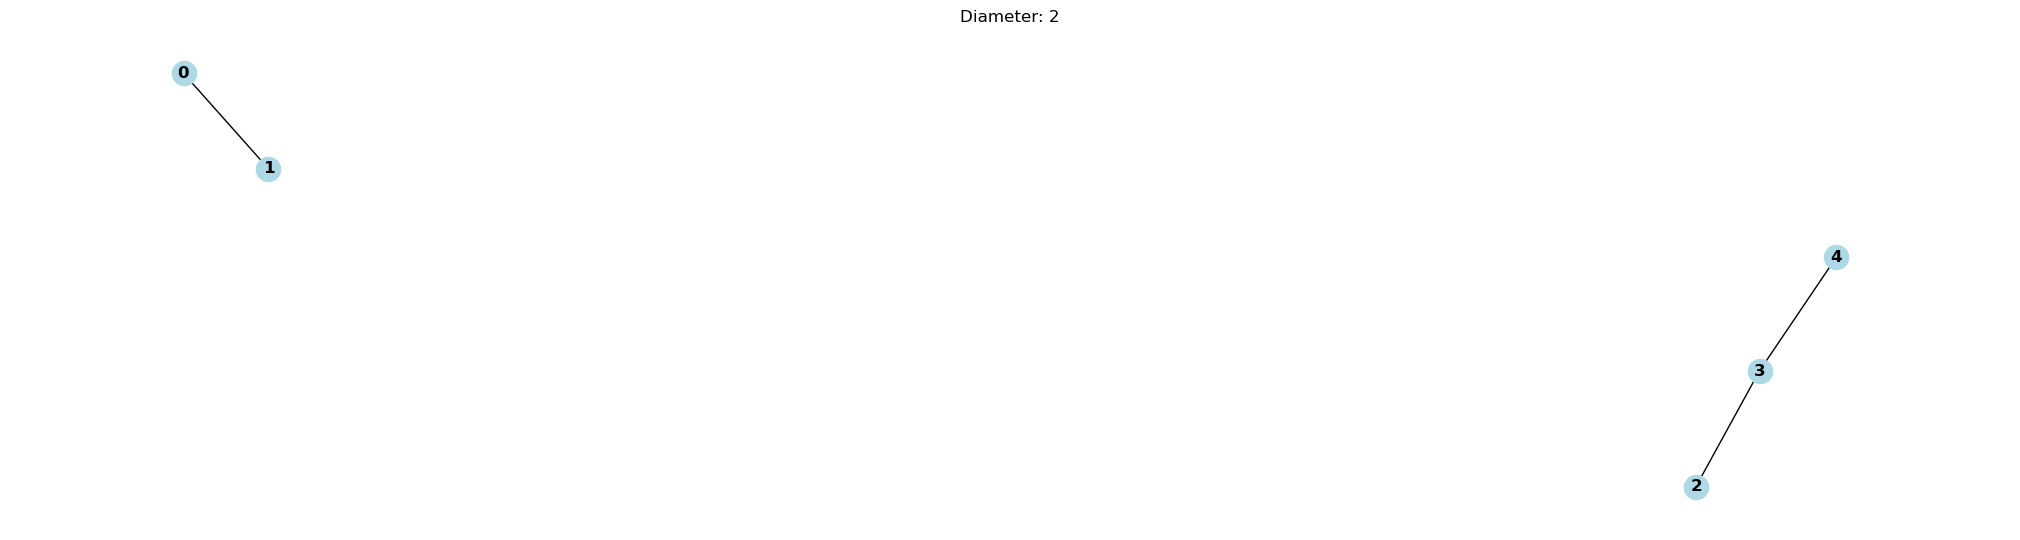

In [9]:
A = np.array([
    [0,1,0,0,0],
    [1,0,0,0,0],
    [0,0,0,1,0],
    [0,0,1,0,1],
    [0,0,0,1,0]
])

G = nx.from_numpy_array(A)

print(len(list(nx.connected_components(G))))
print(list(nx.connected_components(G)))

largest_cc = max(list(nx.connected_components(G)), key=len)
G_sub = G.subgraph(largest_cc)
diam = nx.diameter(G_sub)
print(len(G))

nx.draw(G, with_labels=True, node_color='lightblue', font_weight='bold')
plt.title(f"Diameter: {diam}")
plt.show()

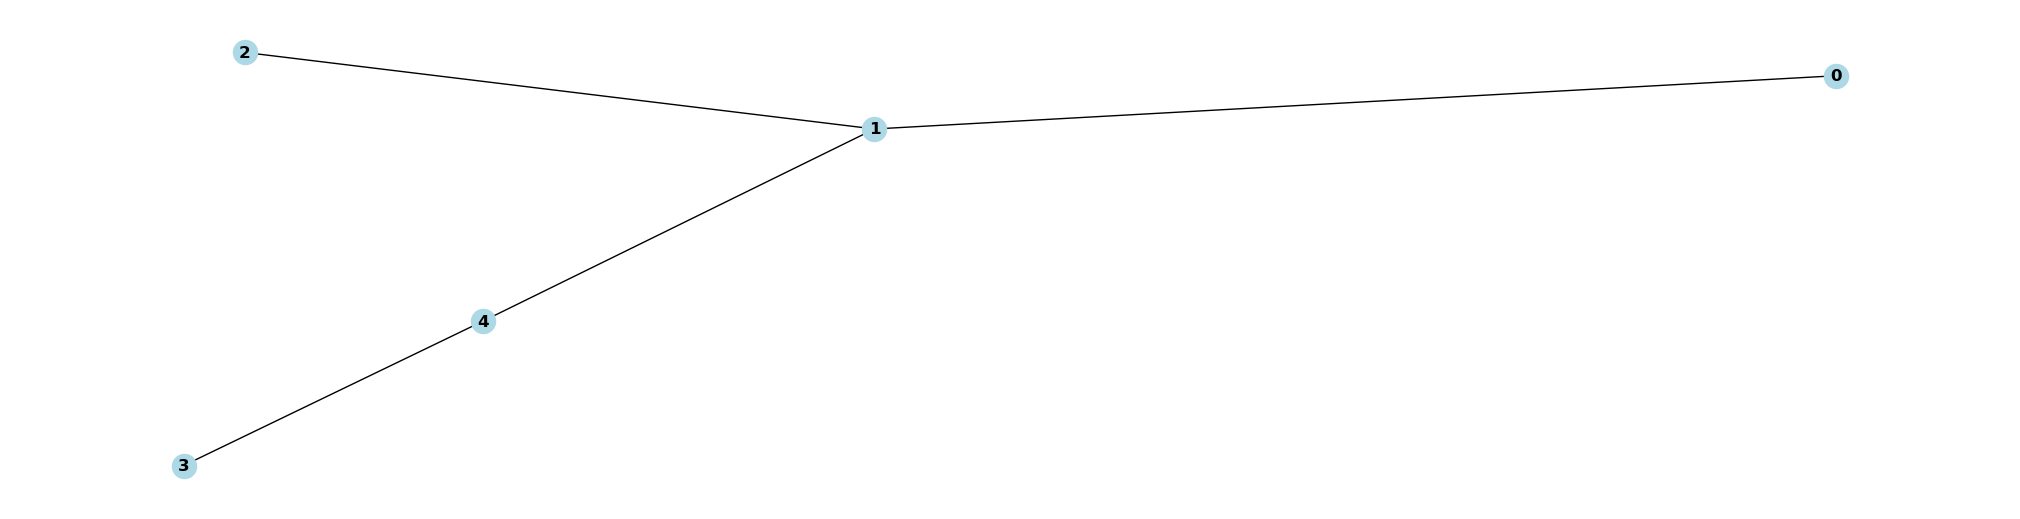

In [19]:
n,p = 5,0.2
weights = np.ones(n)

# Example sparse data
A = sparse.random(n,n, density=p, dtype=float, format="lil")

G = nx.from_scipy_sparse_array(A)

nx.draw(G, with_labels=True, node_color='lightblue', font_weight='bold')
plt.show()

### Test File_io


In [ ]:
# import os
# os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
import traceback
import importlib
import file_io
importlib.reload(file_io)

file_handler = file_io.HDF5FileHandler('/nobackup/autodelete/usr/seyfdall/network_theory/Thinned_Rescomp/results/gamma/16.0/param_set_1/', rho=2.0, p_thin=0.5)
try:
    file_handler.open_file('r')
    file_handler.load_attrs()
    print("Attributes", file_handler.attrs)

    print("Keys", file_handler.file.keys())
    print(f"Attribute Keys", file_handler.file.attrs.keys())
    group_handler = file_handler.get_group_handler(
        f"set_0", n=50, erdos_c=4, gamma=16.0, sigma=0.01, alpha=0.0
    )
    group_handler.load_data()
    print(group_handler.attrs)
    print(group_handler.datasets)
except Exception as e:
    traceback.print_exc()
    print(e)
finally:
    file_handler.close_file()

[Errno 2] Unable to synchronously open file (unable to open file: name = '/nobackup/autodelete/usr/seyfdall/network_theory/Thinned_Rescomp_results/gamma/15.0/param_set_1/_rho=2.0_p_thin=0.5.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


Traceback (most recent call last):
  File "/tmp/ipykernel_2726184/1422705763.py", line 10, in <module>
    file_handler.open_file('r')
    ~~~~~~~~~~~~~~~~~~~~~~^^^^^
  File "/home/seyfdall/network_theory/Thinned_Rescomp/utils/file_io.py", line 55, in open_file
    self.file = h5py.File(self.file_path, mode)
                ~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "/home/seyfdall/.conda/envs/reservoir/lib/python3.13/site-packages/h5py/_hl/files.py", line 564, in __init__
    fid = make_fid(name, mode, userblock_size, fapl, fcpl, swmr=swmr)
  File "/home/seyfdall/.conda/envs/reservoir/lib/python3.13/site-packages/h5py/_hl/files.py", line 238, in make_fid
    fid = h5f.open(name, flags, fapl=fapl)
  File "h5py/_objects.pyx", line 56, in h5py._objects.with_phil.wrapper
  File "h5py/_objects.pyx", line 57, in h5py._objects.with_phil.wrapper
  File "h5py/h5f.pyx", line 102, in h5py.h5f.open
FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/nobackup/

In [24]:
# Manually Run file_io

file_handler = file_io.HDF5FileHandler("./", rho=1.0, p_thin=0.0)
with file_handler:
    for i in range(5):
        if i > 3:
            # file_handler.save_attrs()
            # file_handler.close_file()
            break
        group_handler = file_handler.get_group_handler(f"set_{i}", n=40, erdos_c=4, gamma=15.0, sigma=2.0, alpha=1.0)
        attributes = {"test": 100.0}
        group_handler.add_attrs(**attributes)
        group_handler.save_data()
        group_handler.group.file.flush()
    


Save Data Function
n: 40
erdos_c: 4
gamma: 15.0
sigma: 2.0
alpha: 1.0
test: 100.0

Save Data Function - post clear
alpha: 1.0
erdos_c: 4
gamma: 15.0
n: 40
sigma: 2.0
test: 100.0




Save Data Function
n: 40
erdos_c: 4
gamma: 15.0
sigma: 2.0
alpha: 1.0
test: 100.0

Save Data Function - post clear
alpha: 1.0
erdos_c: 4
gamma: 15.0
n: 40
sigma: 2.0
test: 100.0




Save Data Function
n: 40
erdos_c: 4
gamma: 15.0
sigma: 2.0
alpha: 1.0
test: 100.0

Save Data Function - post clear
alpha: 1.0
erdos_c: 4
gamma: 15.0
n: 40
sigma: 2.0
test: 100.0




Save Data Function
n: 40
erdos_c: 4
gamma: 15.0
sigma: 2.0
alpha: 1.0
test: 100.0

Save Data Function - post clear
alpha: 1.0
erdos_c: 4
gamma: 15.0
n: 40
sigma: 2.0
test: 100.0





In [21]:
with h5py.File("_rho=1.0_p_thin=0.0.h5", 'r') as file:
    for group_name in file.keys():
        print(group_name)
        group = file[group_name]
        print(group.attrs['test'])

set_0_n=40_erdos_c=4_gamma=15.0_sigma=2.0_alpha=1.0
100.0
set_1_n=40_erdos_c=4_gamma=15.0_sigma=2.0_alpha=1.0
100.0
set_2_n=40_erdos_c=4_gamma=15.0_sigma=2.0_alpha=1.0
100.0
set_3_n=40_erdos_c=4_gamma=15.0_sigma=2.0_alpha=1.0
100.0


### Thinned Graph Structure

In [2]:
def erdos(n, mean_degree):
    """ Erdos-Renyi random graph.
        Parameters
            mean_degree (int): average edges per node. Must be an even integer
            n (int): Number of nodes in the network
        Returns
            A (csc sparse matrix): Adjacency matrix of the network
    """
    p = mean_degree/n
    A = nx.adjacency_matrix(nx.erdos_renyi_graph(n,p)).T
    return A

Number of strongly connected components: 448
Sizes of SCCs: [1 2 3 5]


(array([409.,  30.,   9.]),
 array([1., 2., 3., 5.]),
 <BarContainer object of 3 artists>)

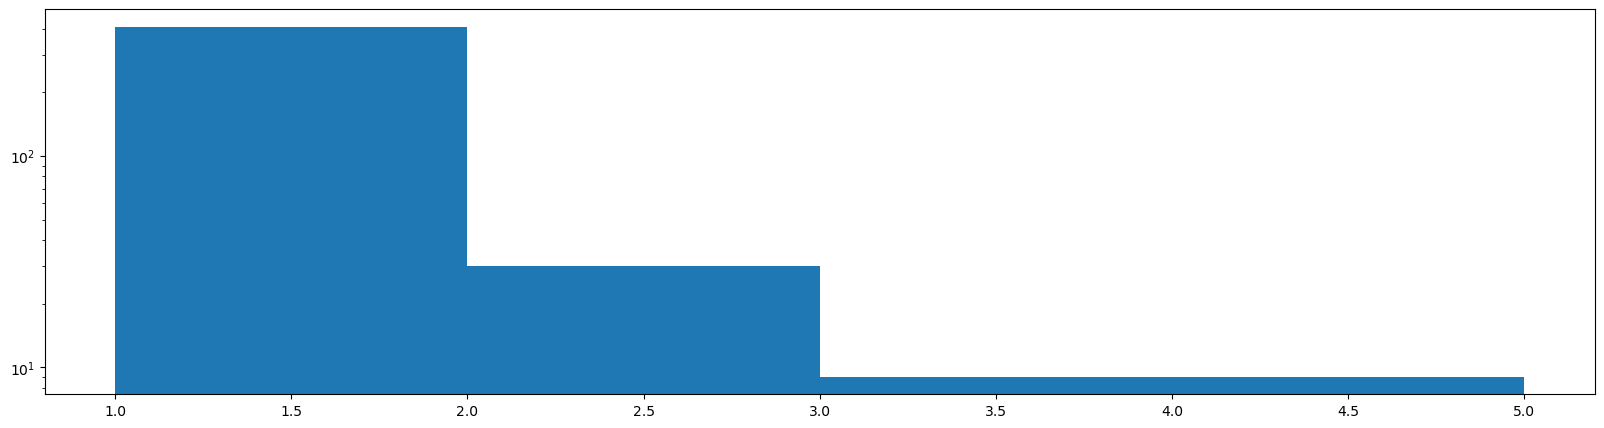

In [53]:
erdos_c = 4
p_thin = 0.95
mean_degree = erdos_c*(1-p_thin)
n = 500

A = erdos(n, mean_degree)

# Convert to a directed graph
G = nx.from_numpy_array(A, create_using=nx.DiGraph)

# Get all strongly connected components
sccs = list(nx.strongly_connected_components(G))

# Number of strongly connected components
num_sccs = len(sccs)

# Sizes of each SCC
scc_sizes = [len(scc) for scc in sccs]

print(f"Number of strongly connected components: {num_sccs}")
print(f"Sizes of SCCs: {np.unique(scc_sizes)}")

plt.hist(scc_sizes, np.unique(scc_sizes), log=True)
# plt.hist(scc_sizes, [1,2,3,4,5])


### Test Correlations

In [5]:
# Example matrices (all same shape m x n)
prediction_time = np.random.rand(4,4)
consistency = np.random.rand(4,4)
diversity1 = np.random.rand(4,4)
diversity2 = np.random.rand(4,4)

# Store in a dict for easy handling
metrics = {
    "prediction_time": prediction_time,
    "consistency": consistency,
    "diversity1": diversity1,
    "diversity2": diversity2
}

# Flatten and build dataframe
df = pd.DataFrame({name: mat.flatten() for name, mat in metrics.items()})

# Global correlation matrix
global_corr = df.corr()
print("Global correlation matrix:\n", global_corr)

row_corrs = []
for i in range(next(iter(metrics.values())).shape[0]):  # iterate rows
    row_df = pd.DataFrame({name: mat[i,:] for name, mat in metrics.items()})
    row_corrs.append(row_df.corr())
print("Row 0 correlations:\n", row_corrs[0])

col_corrs = []
for j in range(next(iter(metrics.values())).shape[1]):  # iterate cols
    col_df = pd.DataFrame({name: mat[:,j] for name, mat in metrics.items()})
    col_corrs.append(col_df.corr())
print("Col 0 correlations:\n", col_corrs[0])

Global correlation matrix:
                  prediction_time  consistency  diversity1  diversity2
prediction_time         1.000000     0.372084   -0.001164   -0.358496
consistency             0.372084     1.000000    0.044109   -0.148767
diversity1             -0.001164     0.044109    1.000000    0.279003
diversity2             -0.358496    -0.148767    0.279003    1.000000
Row 0 correlations:
                  prediction_time  consistency  diversity1  diversity2
prediction_time         1.000000    -0.424410    0.361423   -0.339320
consistency            -0.424410     1.000000    0.270008   -0.234526
diversity1              0.361423     0.270008    1.000000    0.361638
diversity2             -0.339320    -0.234526    0.361638    1.000000
Col 0 correlations:
                  prediction_time  consistency  diversity1  diversity2
prediction_time         1.000000     0.188547   -0.033850   -0.328494
consistency             0.188547     1.000000   -0.339849   -0.678579
diversity1          

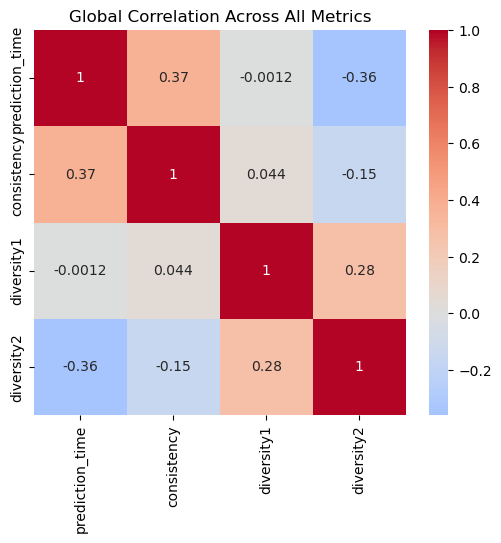

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,5))
sns.heatmap(global_corr, annot=True, cmap="coolwarm", center=0)
plt.title("Global Correlation Across All Metrics")
plt.show()

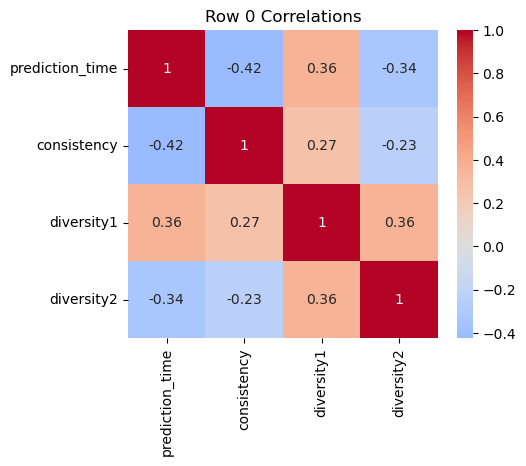

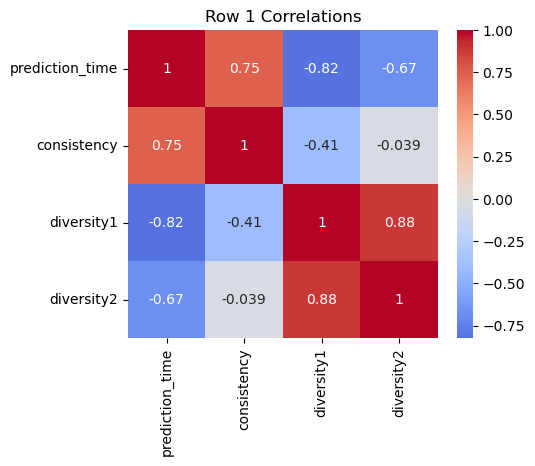

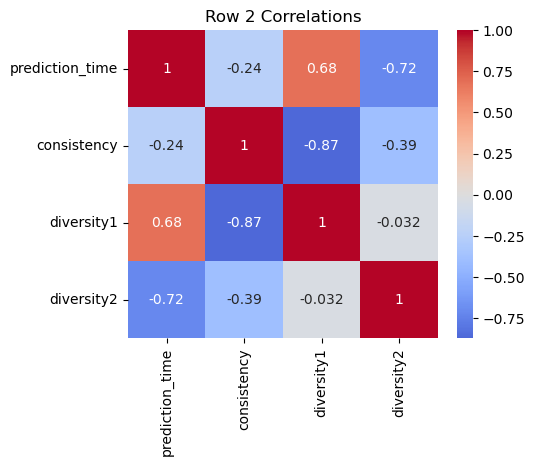

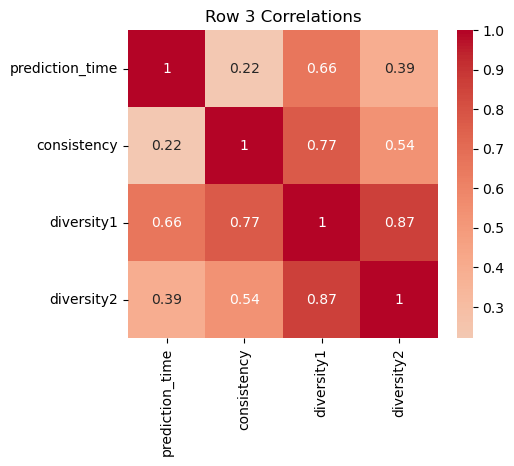

In [7]:
for i, rc in enumerate(row_corrs):
    plt.figure(figsize=(5,4))
    sns.heatmap(rc, annot=True, cmap="coolwarm", center=0)
    plt.title(f"Row {i} Correlations")
    plt.show()

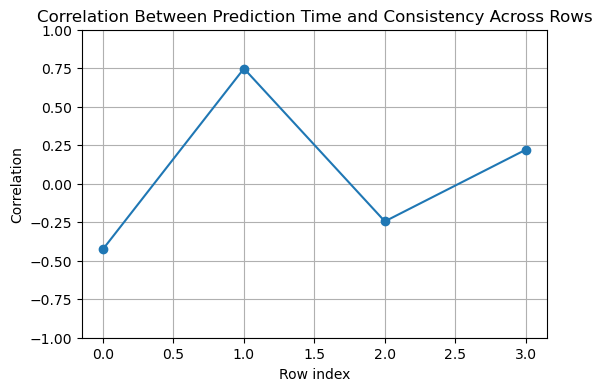

In [8]:
row_corr_vals = [rc.loc["prediction_time", "consistency"] for rc in row_corrs]

plt.figure(figsize=(6,4))
plt.plot(range(len(row_corr_vals)), row_corr_vals, marker='o')
plt.xlabel("Row index")
plt.ylabel("Correlation")
plt.title("Correlation Between Prediction Time and Consistency Across Rows")
plt.ylim(-1, 1)
plt.grid(True)
plt.show()

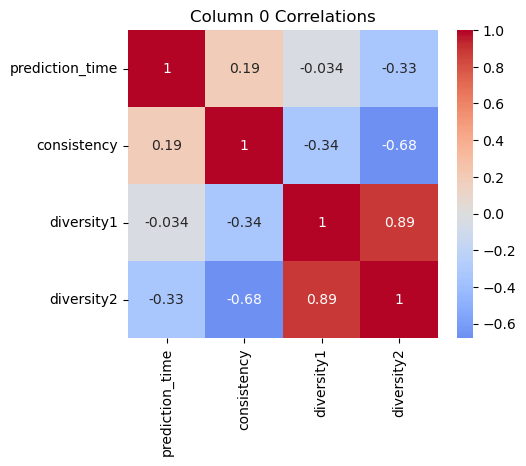

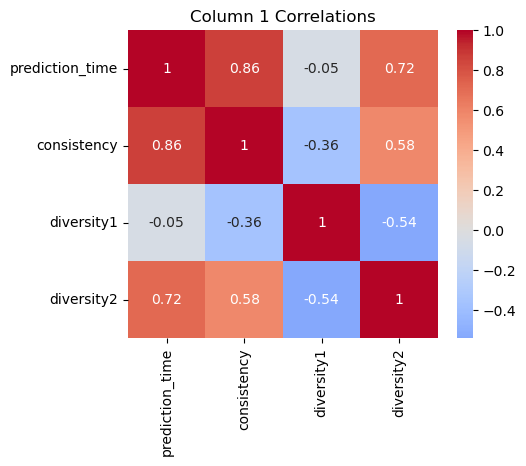

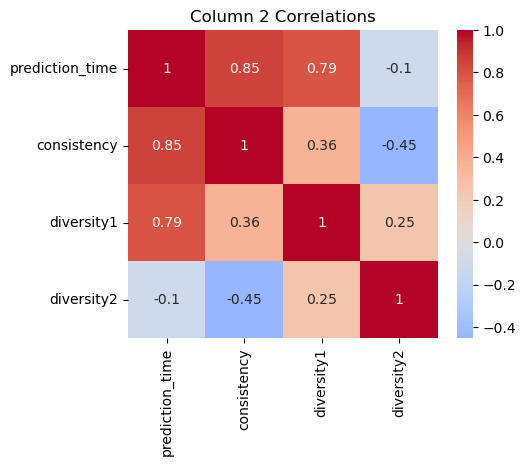

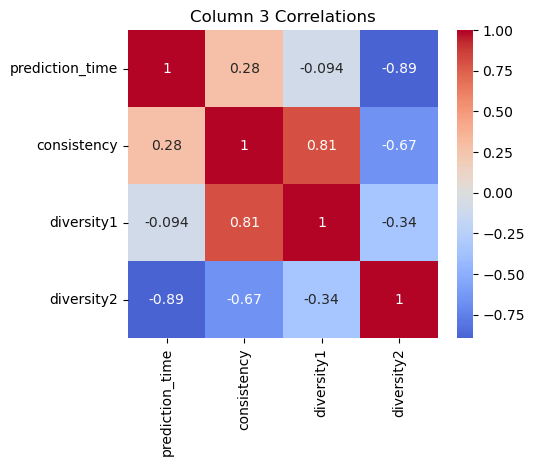

In [9]:
for j, cc in enumerate(col_corrs):
    plt.figure(figsize=(5,4))
    sns.heatmap(cc, annot=True, cmap="coolwarm", center=0)
    plt.title(f"Column {j} Correlations")
    plt.show()

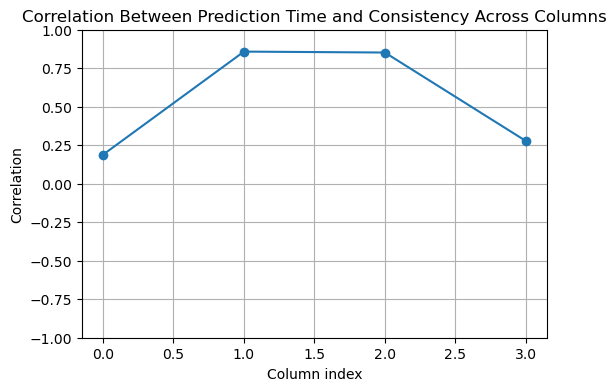

In [10]:
col_corr_vals = [cc.loc["prediction_time", "consistency"] for cc in col_corrs]

plt.figure(figsize=(6,4))
plt.plot(range(len(col_corr_vals)), col_corr_vals, marker='o')
plt.xlabel("Column index")
plt.ylabel("Correlation")
plt.title("Correlation Between Prediction Time and Consistency Across Columns")
plt.ylim(-1, 1)
plt.grid(True)
plt.show()

<Axes: >

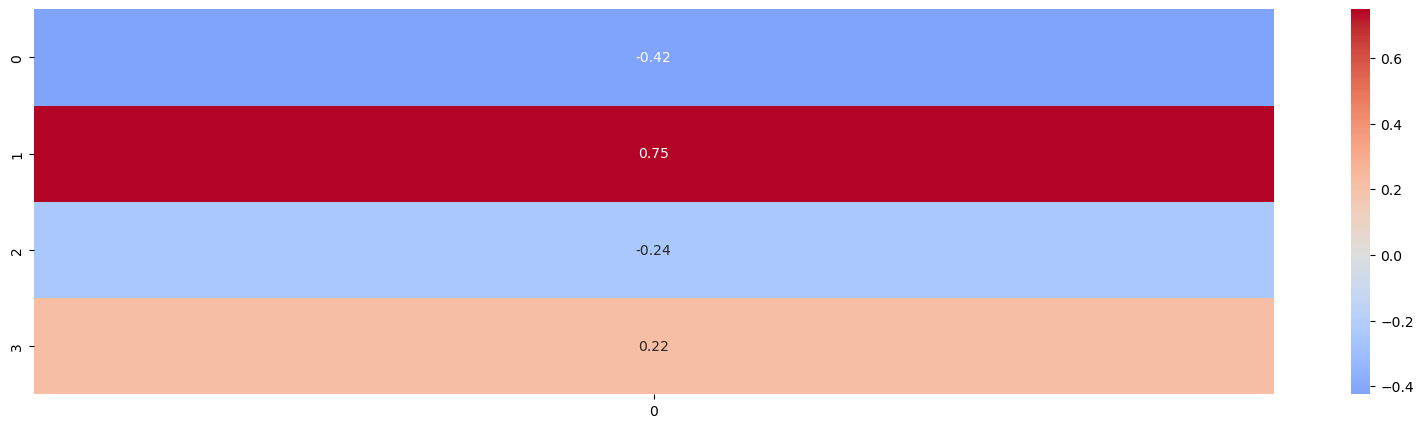

In [11]:
summary_matrix = np.array([[rc.loc["prediction_time", "consistency"]] for rc in row_corrs])
sns.heatmap(summary_matrix, annot=True, cmap="coolwarm", center=0)